# Training quantum embedding kernels for classification

In this tutorial we will dive deeper into the the concept of quantum embedding kernels, or quantum kernels. We will train a quantum kernel based on a similarity measure called the kernel-target alignment and see how the training improves the performance of it as a classifier. We will demonstrate how to use Covalent to orchestrate the whole workflow composed of multiple smaller subtasks. Once the workflow is dispatched, we will be able to track the results of each subtask through the Covalent result manager. In the meantime, all the subtasks constructed can be called as normal Python functions, giving users more flexibility in testing and debugging. For more details about the quantum embedding kernels, we refer the reader to this PennyLane demo: [Training and evaluating quantum kernels](https://pennylane.ai/qml/demos/tutorial_kernels_module.html#training-qeks), which this tutorial is based on.

In addition to Covalent, one first needs to install the following packages in order to fully reproduce the results of this tutorial.

In [ ]:
# !pip install pennylane==0.23.1
# !pip install scikit-learn==1.1.1
# !pip install matplotlib==3.5.1
# !pip install covalent-dask-plugin

Let us begin by starting the Covalent server and importing the necessary packages.

In [12]:
# !covalent start

In [72]:
import pennylane as qml
from pennylane import numpy as np
import covalent as ct
from covalent.executor import DaskExecutor
from dask.distributed import LocalCluster
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.markers import MarkerStyle
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay

cluster = LocalCluster(processes=True)
dask_executor = DaskExecutor(scheduler_address=cluster.scheduler_address)

np.random.seed(2022)

/Users/ruihaoli/opt/miniconda3/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54750 instead
  warnings.warn(


## Defining the quantum kernel

We first generate a dataset with two features and two classes for our classification task using `scikit-learn`'s `make_classification` function. The dataset contains 20 randomly generated points, with 10 in each class. We then do a train/test split with ratio 8:2. Moreover, we include the above two steps in the Covalent workflow as subtasks by adding the `electron` decorator on top of the respective functions.

In [63]:
@ct.electron
def get_data():
    X, y = make_classification(
        n_samples=20, n_features=2, n_redundant=0, random_state=42, n_clusters_per_class=2, flip_y=0.3, class_sep=0.5
    )
    X = X.astype(np.float32)
    y = 2 * (y - 0.5) # rescale labels to be -1, 1
    y = y.astype(int)
    return X, y

@ct.electron
def split_train_test_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)
    return X_train, X_test, y_train, y_test

As mentioned in the beginning, these subtasks can be called as normal Python functions. So we can plot the dataset for visualization.

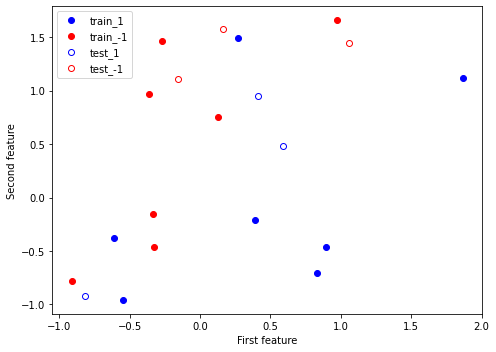

In [65]:
X, y = get_data()
X_train, X_test, y_train, y_test = split_train_test_data(X, y)

fig, ax = plt.subplots(1, 1, figsize=(7, 5), facecolor="w")
ax.plot(X_train[:, 0][y_train==1], X_train[:, 1][y_train==1], "bo", label="train_1")
ax.plot(X_train[:, 0][y_train==-1], X_train[:, 1][y_train==-1], "ro", label="train_-1")
ax.plot(X_test[:, 0][y_test==1], X_test[:, 1][y_test==1], "bo", fillstyle='none', label="test_1")
ax.plot(X_test[:, 0][y_test==-1], X_test[:, 1][y_test==-1], "ro", fillstyle='none', label="test_-1")
ax.set_xlabel("First feature")
ax.set_ylabel("Second feature")
plt.tight_layout()
plt.legend()
plt.show()

Next, we construct the quantum embedding kernel by building a *data reuploading* quantum circuit based on the ansatz given in [Hubregtsen et al. 2021](https://arxiv.org/abs/2105.02276). Specifically, this ansatz uses a repeating layer architecture, where each layer embeds the 2 features into 5 qubits through the angles of $R_Z$ gates. The variational parameters correspond to the angles of a series of $R_Y$ and controlled-$R_Z$ gates. The ansatz diagram of one layer is shown below.

<div align="center">
<img src="././qek_images/qek_circuit.png" style="width: 50%; height: 50%"/>
</div>

A quantum kernel is given by the mutual overlap of the two data-embedding quantum states, i.e.,
$$
\kappa(x_1, x_2) = \vert{\langle \phi(x_2) \vert \phi(x_1) \rangle} \vert^2.
$$
Therefore, to define a quantum kernel function, we construct the following subtasks with Covalent:
- `layer` - Build the quantum circuit for each layer of the ansatz.
- `ansatz` - Construct the ansatz circuit with an arbitrary number of layers.
- `adjoint_ansatz` - Get the adjoint of the ansatz circuit.
- `kernel_circuit` - Construct the quantum embedding kernel circuit based on `ansatz` and `adjoint_ansatz`.
- `kernel` - Return the quantum kernel function based on `kernel_circuit`.

In [19]:
dev = qml.device("default.qubit", wires=5, shots=None)
wires = dev.wires.tolist()

@ct.electron
def layer(x, params, wires, i0=0, inc=1):
    i = i0
    for j, wire in enumerate(wires):
        qml.Hadamard(wires=[wire])
        qml.RZ(x[i % len(x)], wires=[wire])
        i += inc
        qml.RY(params[0, j], wires=[wire])

    qml.broadcast(unitary=qml.CRZ, pattern="ring", wires=wires, parameters=params[1])

@ct.electron
def ansatz(x, params, wires):
    for j, layer_params in enumerate(params):
        layer(x, layer_params, wires, i0=j * len(wires))

@ct.electron
def adjoint_ansatz(ansatz):
    return qml.adjoint(ansatz)

@ct.electron
@qml.qnode(dev)
def kernel_circuit(x1, x2, params):
    ansatz(x1, params, wires=wires)
    adjoint_ansatz(ansatz)(x2, params, wires=wires)
    return qml.probs(wires=wires)

@ct.electron
def kernel(x1, x2, params):
    return kernel_circuit(x1, x2, params)[0]

Now we are in a position to build a support vector machine (SVM) classifier based on the quantum kernel. It consists of two subtasks:
- `init_params` - Randomly initialize the variational parameters.
- `svm` - Build the SVM classifier using the quantum kernel.

To accomplish the second subtask, we first use PennyLane's `qml.kernels.kernel_matrix` function to get the kernel matrix of a full dataset (not just between two data points) based on the given parameters. The kernel matrix is then fed into `scikit-learn`'s support vector classifier (`SVC`), which allows us to build a quantum SVM estimator using the training data.

In [20]:
@ct.electron
def init_params(num_wires, num_layers):
    return np.random.uniform(0, 2 * np.pi, (num_layers, 2, num_wires), requires_grad=True)

@ct.electron
def svm(X, y, params):
    kernel_input = lambda x1, x2: kernel(x1, x2, params)
    svm = SVC(kernel=lambda x1, x2: qml.kernels.kernel_matrix(x1, x2, kernel_input))
    svm.fit(X, y)
    return svm

Finally, we can combine all the subtasks discussed above into a single workflow function called `get_qsvm` with the `lattice` decorator on top. For this tutorial, we will be using 3 layers of the embedding ansatz.

In [66]:
@ct.lattice(executor=dask_executor)
def get_qsvm():
    X, y = get_data()
    X_train, X_test, y_train, y_test = split_train_test_data(X, y)
    params = init_params(5, 3)
    classifier = svm(X_train, y_train, params)
    return classifier, X_train, y_train, X_test, y_test

The workflow is then dispatched to the Covalent server and the results are retrievable once the workflow is finished. One can also track all the results through the Covalent result manager.

In [ ]:
dispatch_id = ct.dispatch(get_qsvm)()
result = ct.get_result(dispatch_id=dispatch_id, wait=True)
qsvm, X_train, y_train, X_test, y_test = result.result

We can also define a function to calculate the accuracy of a classifier, which we can use to test the performance of the SVM classifier built from random parameters on the both the train and test datasets.

In [67]:
qsvm, X_train, y_train, X_test, y_test = get_qsvm()

In [68]:
def calc_accuracy(classifier, X, y_true):
    return 1 - np.count_nonzero(classifier.predict(X) - y_true) / len(y_true)

print(calc_accuracy(qsvm, X_train, y_train))
print(calc_accuracy(qsvm, X_test, y_test))

0.7857142857142857
0.5


Furthermore, we can also plot the decision boundaries of our initial SVM classifier for better visualization.

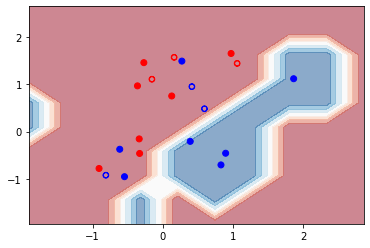

In [80]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

disp = DecisionBoundaryDisplay.from_estimator(qsvm, X, grid_resolution=30, response_method='predict', alpha=0.5, cmap=cm)
disp.ax_.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
disp.ax_.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, marker="$\u25EF$")
plt.show()

We see that ...

## Training the quantum kernel